### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import math
import astropy
from astropy import constants as const
from astropy import units as u
from astropy.table import Table
import rebound
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

In [3]:
#oumuamua_data = pd.read_csv('Oumuamua_Ephemeris_1yr.txt')    #GETTING ERRORS
#print(oumuamua_data)

## Constants + JPL Data

In [4]:
#Orbital elements of known ISOs
a_1I, e_1I = -1.27234500742808, 1.201133796102373
a_2I, e_2I = -.8514922551937886, 3.356475782676596
a_3I, e_3I = -.26391591751781, 6.139587836355706 

### Ephemerides data tables:

In [5]:
#data2 = np.genfromtxt('Atlas_Ephemeris_1yr.txt',delimiter=',',dtype=str,usecols=np.arange(0,21))#,skip_header=14)
#dat4 = Table.read('Atlas_Ephemeris_1yr.txt', format='txt')


In [6]:
def get_headers(filepath):
    with open(filepath, 'r') as file:
        for line in file:
            if 'Date__(UT)__HR:MN' in line:
                split_headers = line.strip().split(',')
                header_list = [item for item in split_headers if item]
                fixed_header_list = [item.replace(" ", "") for item in header_list]    #remove white space in headers
  #              print(header_list)
    return fixed_header_list

def get_data(filepath): 
    data_rows = []  
    with open(filepath, "r") as file:
        in_data_section = False
        for line in file:
            line = line.strip()
            if line == "$$SOE":            #start tracking data at this marker
                in_data_section = True
                continue
            elif line == "$$EOE":          #stop tracking data at this marker
                break
            if in_data_section:
                split_line = line.split(',')                          #split up entries in each row
                datalist = [item for item in split_line if item]      #create list with the data for each row
   #             print(datalist)
                fixed_list = [item.lstrip() for item in datalist]     #remove leading white space in each entry
   #             print(fixed_list)     
                data_rows.append(fixed_list)
    return(data_rows)

def read_horizons_file(filepath): 
    colheaders = get_headers(filepath)
    data = get_data(filepath)
    df = pd.DataFrame(data, columns=colheaders)
    return df

In [7]:
filepath1 = './oumuamua_jpldata_csv.txt'
filepath2 = './borisov_jpldata_csv.txt'
filepath3 = './atlas_jpldata_csv.txt'

data1I = read_horizons_file(filepath1)
data2I = read_horizons_file(filepath2)
data3I = read_horizons_file(filepath3)

In [8]:
#data1I
data2I
#data3I

,Date__(UT)__HR:MN,,,R.A._(ICRF),DEC__(ICRF),R.A.__(a-app),DEC_(a-app),dRA*cosD,d(DEC)/dt,Azi_(a-app),...,S-T-O,PsAng,PsAMV,GlxLon,GlxLat,Sky_motion,Sky_mot_PA,RelVel-ANG,Lun_Sky_Brt,sky_SNR
0,2019-Feb-28 00:00,N,,04 10 05.45,+56 59 45.9,04 11 38.02,+57 02 48.3,7.733558,-16.6740,347.293898,...,8.9338,78.884,292.576,147.522924,3.936983,0.3063352,155.11762,-24.66064,n.a.,n.a.
1,2019-Mar-01 00:00,N,,04 10 29.72,+56 53 09.3,04 12 02.14,+56 56 11.0,8.133578,-16.6432,346.803923,...,8.9685,78.384,292.980,147.638526,3.893707,0.3087397,153.95517,-24.38357,n.a.,n.a.
2,2019-Mar-02 00:00,N,,04 10 55.08,+56 46 33.6,04 12 27.37,+56 49 34.6,8.533342,-16.6096,346.315946,...,9.0017,77.892,293.378,147.755961,3.852577,0.3112237,152.80773,-24.11748,n.a.,n.a.
3,2019-Mar-03 00:00,N,,04 11 21.52,+56 39 58.9,04 12 53.67,+56 42 59.2,8.932711,-16.5731,345.830043,...,9.0335,77.407,293.770,147.875209,3.813618,0.3137859,151.67587,-23.86263,n.a.,n.a.
4,2019-Mar-04 00:00,N,,04 11 49.04,+56 33 25.1,04 13 21.06,+56 36 24.7,9.331546,-16.5339,345.346289,...,9.0637,76.930,294.157,147.996252,3.776854,0.3164248,150.56016,-23.61923,n.a.,n.a.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-Feb-24 00:00,N,,12 57 56.14,-64 10 01.3,12 59 13.19,-64 16 16.9,3.015772,-45.6977,154.947662,...,21.6551,321.826,290.237,303.643849,-1.301862,0.7632847,176.22430,37.531759,n.a.,n.a.
362,2020-Feb-25 00:00,N,m,12 58 04.63,-64 27 46.0,12 59 21.96,-64 34 01.7,2.351894,-44.4874,154.979933,...,21.5112,322.644,289.841,303.651704,-1.597955,0.7424926,176.97379,38.418638,n.a.,n.a.
363,2020-Feb-26 00:00,N,m,12 58 10.83,-64 45 01.5,12 59 28.42,-64 51 17.5,1.702308,-43.2809,155.013271,...,21.3672,323.475,289.460,303.655353,-1.885861,0.7219060,177.74762,39.321454,n.a.,n.a.
364,2020-Feb-27 00:00,N,m,12 58 14.72,-65 01 48.1,12 59 32.57,-65 08 04.2,1.067564,-42.0783,155.047653,...,21.2230,324.318,289.097,303.654942,-2.165605,0.7015313,178.54667,40.240228,n.a.,n.a.


## Calculate apparent sky motion as a function of orbital elements

In [9]:
#calculation in MKS units --> OUTPUTS IN RADIANS PER SECOND
def calc_appskymotion_gen(starmass_Msun, a_AU, e, f, f_earth): 
    M_sun_kg = 1.98840987e+30 #kg
    G = 6.6743e-11 #m^3/kgs^2
    a = a_AU * 1.49597871e+11 #m 
    
    gamma = (a)*(1-(e**2)) / (1+(e*np.cos(f)))  #units of meters
    
    factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + (1)       #units of meters^2
    factor2 = gamma * ( (2*np.cos(f))+e)*np.sin(f) - np.sin(f+f_earth) - (e*np.sin(f_earth) )  
    
    Lambda = ( (G*starmass_Msun*M_sun_kg) / (a*(1-(e**2))) )**0.5
    
    coeff2 = ( (1) / ((gamma**2) - (2*gamma*np.cos(f-f_earth)) + (1)) )**1.5
    
    xterm = ( -factor1*np.sin(f) ) + ( factor2*(gamma*np.cos(f) - np.cos(f_earth)) )
    yterm = ( -factor1*(e + np.cos(f)) ) + ( factor2*(gamma*np.sin(f) - np.sin(f_earth)) )
  
    mag_skymotion = Lambda*coeff2*([(xterm**2)+(yterm**2)]**0.5)
    return mag_skymotion

In [10]:
#calculation in MKS units --> OUTPUTS IN RADIANS PER SECOND
def calc_appskymotion(starmass_Msun, a, e, f, f_earth): 
#    M_sun = 1.98840987e+30 #kg
#    G = 6.6743e-11 #m^3/kgs^2
#    a = a_AU * 1.49597871e+11 #m 
    
    gamma = (a*u.au)*(1-(e**2)) / (1+(e*np.cos(f)))  #units of au
    
    factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)*u.au) + ((1*u.au)**2)       #units of au^2
    factor2 = (gamma*((2*np.cos(f))+e)*np.sin(f)) - (np.sin(f+f_earth)*u.au) - (e*np.sin(f_earth)*u.m) #units of au 
    
    Lambda = ( (const.G*starmass_Msun*const.M_sun).to((u.au**3)/(u.s**2)) / (a*u.au*(1 - (e**2))) )**0.5   #units of au/s
    
    coeff2 = ( (1) / ((gamma**2) - (2*gamma*np.cos(f-f_earth)*u.au) + ((1*u.au)**2)) )**1.5   #units of au^-3/2
    
    xterm = ( -factor1*np.sin(f) ) + ( factor2*((gamma*np.cos(f)) - (np.cos(f_earth)*u.au)) )   #units of au^2
    yterm = ( -factor1*(e + np.cos(f)) ) + ( factor2*((gamma*np.sin(f)) - (np.sin(f_earth)*u.au)) )  #units of au^2
  
    mag_skymotion = Lambda*coeff2*([(xterm**2)+(yterm**2)]**0.5)
    return mag_skymotion

In [11]:
#calculation in MKS units --> OUTPUTS IN RADIANS PER SECOND
def calc_appskymotion_solar(a_AU, e, f, f_earth): 
    M_sun = 1.98840987e+30 #kg
    G = 6.6743e-11 #m^3/kgs^2
    a = a_AU * 1.49597871e+11 #m
    
    gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
    
    factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1
    factor2 = gamma*((2*np.cos(f))+e)*np.sin(f) - np.sin(f+f_earth) - (e*np.sin(f_earth))
    
    coeff1 = ((G * M_sun) / (a*(1 - (e**2))))**0.5
    coeff2 = (1 / ((gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1))**1.5
    
    xterm = ( -factor1*np.sin(f) ) + ( factor2*(gamma*np.cos(f) - np.cos(f_earth)) )
    yterm = ( -factor1*(e + np.cos(f)) ) + ( factor2*(gamma*np.sin(f) - np.sin(f_earth)) )
  
    mag_skymotion_rad = coeff1*coeff2*(((xterm**2)+(yterm**2))**0.5)
    return mag_skymotion_rad

In [12]:
#calculates largest possible true anomaly angle for hyperbolic orbit of given eccentricity
def calc_hypanomaly_limit(e_hyp):
    f_limit = np.arccos(-1/e_hyp)
    return f_limit

#### test function

In [13]:
#test=calc_appskymotion_solar( a_3I, e_3I, f=0, f_earth=np.pi/2)
#print(f'Astropy Units = {test} vs. Manual = {skymot_peri3I}')
#print(test.u)

In [14]:
206265*calc_appskymotion_solar(a_3I, e_3I, f=0, f_earth=0)

np.float64(0.06946067405282343)

In [15]:
skymot_peri1I = 206265*calc_appskymotion_solar(a_1I, e_1I, f=0, f_earth=np.pi/2)
print(f'\'Oumuamua Sky Motion @ Perihelion = {skymot_peri1I} arcsec/sec')
skymot_peri2I = 206265*calc_appskymotion_solar(a_2I, e_2I, f=0, f_earth=np.pi/2)
print(f'Borisov Sky Motion @ Perihelion = {skymot_peri2I} arcsec/sec')
skymot_peri3I = 206265*calc_appskymotion_solar(a_3I, e_3I, f=0, f_earth=np.pi/2)
print(f'Atlas Sky Motion @ Perihelion = {skymot_peri3I} arcsec/sec')

'Oumuamua Sky Motion @ Perihelion = 0.47063210405001477 arcsec/sec
Borisov Sky Motion @ Perihelion = 0.030157502060340784 arcsec/sec
Atlas Sky Motion @ Perihelion = 0.06946067405248113 arcsec/sec


## Apparent motion of each object through time

In [16]:
def get_xy_anomaly_skymotion(a, e, f_earth):
    f_range = np.linspace(-calc_hypanomaly_limit(e), calc_hypanomaly_limit(e), 1000)
    xvals = f_range #convert to time, somehow????
    yvals = 206265*calc_appskymotion_solar(a, e, f_range, f_earth)
    return xvals, yvals

In [ ]:
def plot_skymotion_axs(a, e, f_earth=np.pi/2, ax=None): 
    x, y = get_xy_anomaly_skymotion(a, e, f_earth)
        
    ax.scatter(x, y, s=2) 
    x_ymax = x[np.nanargmax(y)]
    ax.axvline(x_ymax, color='red', linestyle='--', label=f"Max: {np.nanmax(y):.2f}\"/min\nf={x_ymax:.2f}")

    ax.legend(loc='upper left', fontsize = 'x-small')
    
    if ax is axs[2]:
        ax.set_xlabel("True Anomaly [rad]")
    if ax is axs[1]:
        ax.set_ylabel("Apparent Sky Motion [arcsec/sec]")


/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: divide by zero encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:9: RuntimeWarning: invalid value encountered in subtract
  factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:13: RuntimeWarning: invalid value encountered in subtract
  coeff2 = (1 / ((gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1))**1.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:16: RuntimeWarning: invalid value encountered in add
  yterm = ( -factor1*(e + np.cos(f)) ) + ( factor2*(gamma*np.sin(f) - np.sin(f_earth)) )
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/2056308122.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.

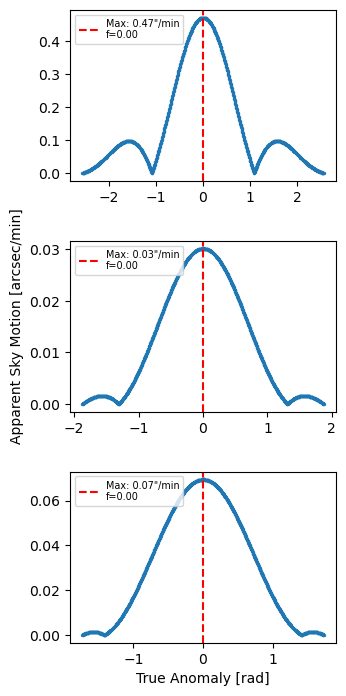

In [18]:
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8.7*cm, 2.4*8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

plot_skymotion_axs(a_1I, e_1I, ax=axs[0])
plot_skymotion_axs(a_2I, e_2I, ax=axs[1])
plot_skymotion_axs(a_3I, e_3I, ax=axs[2])

#plt.show()
plt.savefig('calculated_skymotion_timeish1',bbox_inches='tight', dpi=600)

### Compare to real data: 

##### Functions to:
1) obtain dataframe from Horizons Ephemeris file
2) plot sky motion as function of date w/ given labels

In [19]:
def get_headers(filepath):
    with open(filepath, 'r') as file:
        for line in file:
            if 'Date__(UT)__HR:MN' in line:
                split_headers = line.strip().split(',')
                header_list = [item for item in split_headers if item]
                fixed_header_list = [item.replace(" ", "") for item in header_list]    #remove white space in headers
  #              print(header_list)
    return fixed_header_list

def get_data(filepath): 
    data_rows = []  #To store the data between $$SOE and $$EOE
    with open(filepath, "r") as file:
        in_data_section = False
        for line in file:
            line = line.strip()
            if line == "$$SOE":            #start tracking data at this marker
                in_data_section = True
                continue
            elif line == "$$EOE":          #stop tracking data at this marker
                break
            if in_data_section:
                split_line = line.split(',')                          #split up entries in each row
                datalist = [item for item in split_line if item]      #create list with the data for each row
   #             print(datalist)
                fixed_list = [item.lstrip() for item in datalist]     #remove leading white space in each entry
   #             print(fixed_list)     
                data_rows.append(fixed_list)
    return(data_rows)

def read_horizons_file(filepath): 
    colheaders = get_headers(filepath)
    data = get_data(filepath)
    df = pd.DataFrame(data, columns=colheaders)
    return df

In [20]:
def axplot_skymotion_date(dataframe, label_dates=None, discdateidx=1, ax=None): 
    if ax is None:
        ax = plt.gca()  # Use current axes if none provided
    
    xaxis = dataframe['Date__(UT)__HR:MN']
    yaxis = [float(item) for item in dataframe['Sky_motion']]

    ax.scatter(range(len(xaxis)), yaxis, s=2)  # Use numeric x for consistent spacing

    if label_dates is not None:
        dates_only = [dt.split(' ')[0] for dt in xaxis]

        tick_positions = [i for i, date in enumerate(dates_only) if date in label_dates]
        tick_labels = [dates_only[i] for i in tick_positions]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)#, rotation=45)

        disc_date = label_dates[discdateidx]
        disc_index = dates_only.index(disc_date)
        discmotion = dataframe['Sky_motion'][disc_index]
        ax.axvline(x=disc_index, color='orange', linestyle='dotted', label=f"{float(discmotion):.2f}\"/min")
        dataframe['Sky_motion'] = pd.to_numeric(dataframe['Sky_motion'], errors='coerce')  # Safely convert string entries to floats
        max_index = dataframe['Sky_motion'].idxmax()
        max_date = dates_only[max_index]
        max_motion = dataframe['Sky_motion'][max_index]
        ax.axvline(x=max_index, color='red', linestyle='--', label=f"Max: {float(max_motion):.2f}\"/min\n{max_date}")

    ax.legend(loc='upper left', fontsize = 'x-small')
    if ax is axs[2]:
        ax.set_xlabel("Date (UT)")
    if ax is axs[1]:
        ax.set_ylabel("Apparent Sky Motion [arcsec/min]")


##### Generate dataframes for given files

In [21]:
filepath1 = './horizons_results1.txt'
filepath2 = './horizons_results2.txt'
filepath3 = './horizons_results3.txt'

data1I = read_horizons_file(filepath1)
data2I = read_horizons_file(filepath2)
data3I = read_horizons_file(filepath3)

In [22]:
filepath2a = './horizons_borisov_2yr.txt'
filepath3a = './horizons_atlas_2yr.txt'

data2I_2yr = read_horizons_file(filepath2a)
data3I_2yr = read_horizons_file(filepath3a)

##### Plot apparent motion vs. time(date)

In [23]:
specific_dates_1 = ['2017-Apr-17', '2017-Oct-17', '2018-Apr-17']
specific_dates_2 = ['2019-Feb-28', '2019-Aug-30', '2020-Feb-28']
specific_dates_3 = ['2025-Jan-01', '2025-Jul-01', '2026-Jan-01']

/opt/anaconda3/envs/my-rebound-env/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/anaconda3/envs/my-rebound-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


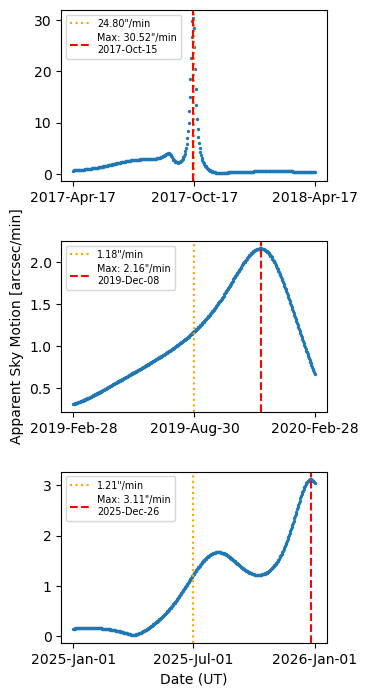

In [24]:
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8.7*cm, 2.4*8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

axplot_skymotion_date(data1I, label_dates = specific_dates_1, discdateidx=1, ax=axs[0])
axplot_skymotion_date(data2I, label_dates = specific_dates_2, discdateidx=1, ax=axs[1])
axplot_skymotion_date(data3I, label_dates = specific_dates_3, discdateidx=1, ax=axs[2])

#plt.tight_layout()
#plt.show()
#plt.savefig('jpl_skymotion_time1',bbox_inches='tight', dpi=600)

/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/1704058764.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('jpl_skymotion_time2',bbox_inches='tight', dpi=600)
/opt/anaconda3/envs/my-rebound-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


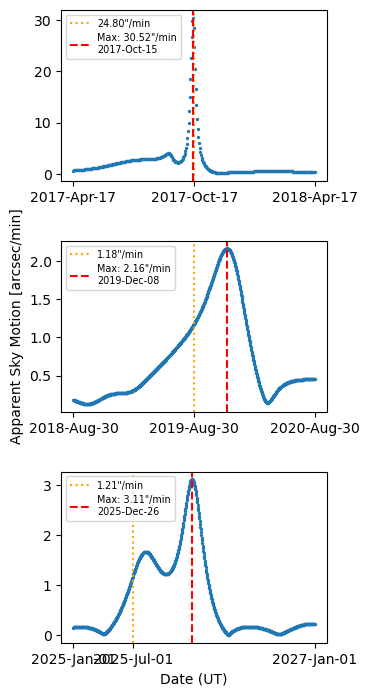

In [25]:
specific_dates_1 = ['2017-Apr-17', '2017-Oct-17', '2018-Apr-17']
specific_dates_2a = ['2018-Aug-30', '2019-Aug-30', '2020-Aug-30']
specific_dates_3a = ['2025-Jan-01', '2025-Jul-01', '2027-Jan-01']

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8.7*cm, 2.4*8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

axplot_skymotion_date(data1I, label_dates = specific_dates_1, discdateidx=1, ax=axs[0])
axplot_skymotion_date(data2I_2yr, label_dates = specific_dates_2a, discdateidx=1, ax=axs[1])
axplot_skymotion_date(data3I_2yr, label_dates = specific_dates_3a, discdateidx=1, ax=axs[2])

#plt.tight_layout()
#plt.show()
plt.savefig('jpl_skymotion_time2',bbox_inches='tight', dpi=600)

In [26]:
data1I.head()

,Date__(UT)__HR:MN,,,R.A._(ICRF),DEC__(ICRF),R.A.__(a-app),DEC_(a-app),dRA*cosD,d(DEC)/dt,Azi_(a-app),...,PsAng,PsAMV,GlxLon,GlxLat,Tru_Anom,Sky_motion,Sky_mot_PA,RelVel-ANG,Lun_Sky_Brt,sky_SNR
0,2017-Apr-17 00:00,*,,18 59 02.25,+35 34 22.8,18 59 39.47,+35 35 41.5,-3.96687,37.86873,316.365207,...,255.616,251.997,66.032823,13.958278,225.6915,0.634599,354.01990,-63.08772,n.a.,n.a.
1,2017-Apr-18 00:00,*,,18 58 53.05,+35 49 45.4,18 59 30.16,+35 51 04.0,-4.77408,38.35383,317.096569,...,254.752,249.636,66.262250,14.089039,225.7525,0.644164,352.90463,-62.90322,n.a.,n.a.
2,2017-Apr-19 00:00,*,,18 58 42.19,+36 05 19.7,18 59 19.17,+36 06 38.1,-5.60272,38.83929,317.840767,...,253.880,247.278,66.492807,14.225859,225.8142,0.654022,351.79149,-62.71098,n.a.,n.a.
3,2017-Apr-20 00:00,*,,18 58 29.60,+36 21 05.7,18 59 06.46,+36 22 23.8,-6.45341,39.32469,318.597962,...,252.998,244.927,66.724476,14.368847,225.8765,0.664178,350.68050,-62.51099,n.a.,n.a.
4,2017-Apr-21 00:00,*,,18 58 15.22,+36 37 03.4,18 58 51.96,+36 38 21.2,-7.32676,39.80957,319.368307,...,252.106,242.585,66.957236,14.518117,225.9396,0.674636,349.57168,-62.30327,n.a.,n.a.


In [27]:
data1I['Tru_Anom']

0      225.6915
1      225.7525
2      225.8142
3      225.8765
4      225.9396
         ...   
361    137.3464
362    137.3780
363    137.4094
364    137.4405
365    137.4714
Name: Tru_Anom, Length: 366, dtype: object

In [28]:
x_real, y_real = data1I['Tru_Anom'], data1I['Sky_motion']

x_real_deg = [float(item) for item in data1I['Tru_Anom']]
x_real_rad = np.array(x_real_deg)*np.pi/180
#x_real_deg
#x_real_rad

/opt/anaconda3/envs/my-rebound-env/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/anaconda3/envs/my-rebound-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


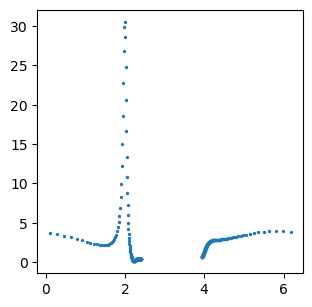

In [29]:
x_calc, y_calc = get_xy_anomaly_skymotion(a_1I, e_1I, f_earth=np.pi/2)

fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(8.7*cm, 8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

#axs.scatter(x_calc, y_calc, s=2) 
axs.scatter(x_real_rad, y_real, s=2) 



## Apparent motion (semimajor axis, eccentricity)
##### Set object true anomaly, earth true anomaly

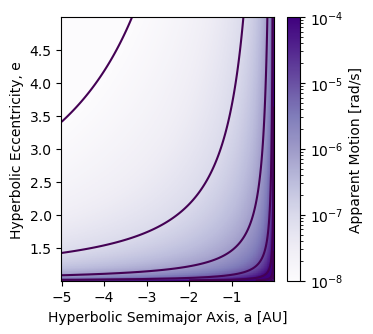

In [30]:
a_values = np.arange(-5, 0, 0.01)
e_values = np.arange(1.01, 5, 0.01)

X,Y = meshgrid(a_values, e_values) 
Z = calc_appskymotion_solar(X, Y, f=0, f_earth=0)

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(1, 1, tight_layout=False,figsize=(8.7*cm,8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

colorplot = axs.pcolormesh(a_values, e_values, Z,cmap='Purples', norm=colors.LogNorm(vmin=1E-8, vmax=1E-4))
contours = axs.contour(X,Y,Z, levels = [1E-10, 1E-9, 1E-8, 1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
axs.set_xlabel( 'Hyperbolic Semimajor Axis, a [AU]')
axs.set_ylabel('Hyperbolic Eccentricity, e')
colorbar(colorplot, label = 'Apparent Motion [rad/s]')


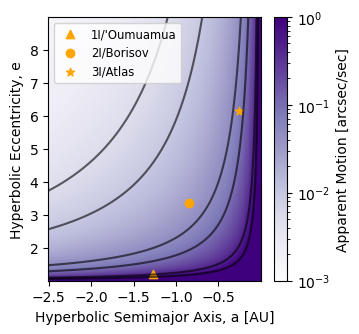

In [31]:
a_values = np.arange(-2.5, 0, 0.01)
e_values = np.arange(1.01, 9, 0.01)

X,Y = meshgrid(a_values, e_values) 
Z = 206265*calc_appskymotion_solar(X, Y, f=0, f_earth=0)

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(8.7*cm,8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

colornorm=colors.LogNorm(vmin=1E-3, vmax=1)
contourlvls=[1E-3, 5E-3, 1E-2, 5E-2, 0.1, 0.5, 1]

colorplot = axs.pcolormesh(a_values, e_values, Z,cmap='Purples', norm=colornorm)
contours = axs.contour(X,Y,Z, levels = contourlvls, colors='k', alpha=0.6)
axs.scatter(a_1I, e_1I, label='1I/\'Oumuamua', marker='^', color='orange')
axs.scatter(a_2I, e_2I, label='2I/Borisov', marker='o', color='orange')
axs.scatter(a_3I, e_3I, label='3I/Atlas', marker='*', color='orange')
axs.set_xlabel( 'Hyperbolic Semimajor Axis, a [AU]')
axs.set_ylabel('Hyperbolic Eccentricity, e')
#axs.clabel(contours, fontsize='small')
axs.legend(fontsize='small', loc='upper left')
colorbar(colorplot, label = 'Apparent Motion [arcsec/sec]')
#plt.savefig('a_vs_e_arcsec_sec_wISO_contour',bbox_inches='tight', dpi=600)

/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:12: RuntimeWarning: invalid value encountered in sqrt
  coeff1 = ((G * M_sun) / (a*(1 - (e**2))))**0.5


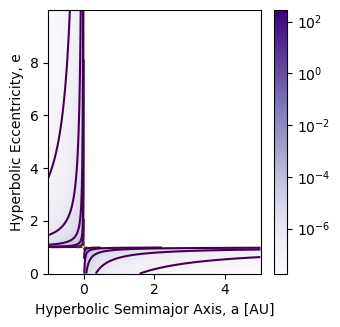

In [32]:
a_values = np.arange(-1.001, 5.001, 0.01)
e_values = np.arange(0.001, 10.001, 0.01)

X,Y = meshgrid(a_values, e_values) 
Z = calc_appskymotion_solar(X, Y, f=0, f_earth=0)

cm = 1/2.54
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(8.7*cm,8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

colorplot = axs.pcolormesh(a_values, e_values, Z,cmap='Purples', norm=colors.LogNorm())
contours = axs.contour(X,Y,Z, levels = [1E-10, 1E-9, 1E-8, 1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
axs.set_xlabel('Hyperbolic Semimajor Axis, a [AU]')
axs.set_ylabel('Hyperbolic Eccentricity, e')
colorbar(colorplot)

### Try for Varying Values of f and f_earth

In [33]:
#Orbital elements of known ISOs
a_1I, e_1I = -1.27234500742808, 1.201133796102373
a_2I, e_2I = -.8514922551937886, 3.356475782676596
a_3I, e_3I = -.26391591751781, 6.139587836355706 

In [34]:
a_values = np.linspace(-5, 0, 1000)
def peri_dist(e):
    distance_array = a_values*(1-(e**2))
    return distance_array
#print(peri_dist(e_3I))

## Apparent motion (true anomaly, periapse distance)
##### Set eccentricity, earth true anomaly

In [35]:
def perifocal_distance(a,e):
    q = a*(1-e)
    return q

def semimajoraxis_vals(e, qrange):
    a_values = qrange/(1-e)
    return a_values

def trueanomaly_vals(e):
    fvals = np.linspace(-calc_hypanomaly_limit(e), calc_hypanomaly_limit(e), 1000)
    return fvals

def f_q_skymotion_grid(fvals, qvals, e, f_earth):  #plot true anomaly
    X,Y = meshgrid(fvals, qvals) 
    avals = semimajoraxis_vals(e, qvals)
    Z = 206265*calc_appskymotion_solar(avals, e, X, f_earth)
#    a_vals = semimajoraxis_vals(e)
    return X,Y,Z

def make_plot(index, labelstring, set_a, set_e, qrange, f_earth, colornorm, contourlevels):
    frange = trueanomaly_vals(set_e)
    X, Y, Z = f_q_skymotion_grid(frange, qrange, set_e, f_earth)
    colorplot = axs[index].pcolormesh(frange, qrange, Z, cmap='Purples', norm=colornorm)
    contours = axs[index].contour(X, Y, Z, levels = contourlevels, linestyles = 'dotted', alpha = 0.7)
    q = perifocal_distance(set_a,set_e)
    axs[index].axhline(q, linestyle='--', color='orange', alpha=0.8, label=labelstring)
    axs[index].legend(fontsize='small')
    axs[index].clabel(contours, fontsize = 'x-small')
    return colorplot

/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: divide by zero encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:9: RuntimeWarning: invalid value encountered in subtract
  factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:13: RuntimeWarning: invalid value encountered in subtract
  coeff2 = (1 / ((gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1))**1.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:16: RuntimeWarning: invalid value encountered in add
  yterm = ( -factor1*(e + np.cos(f)) ) + ( factor2*(gamma*np.sin(f) - np.sin(f_earth)) )


/opt/anaconda3/envs/my-rebound-env/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


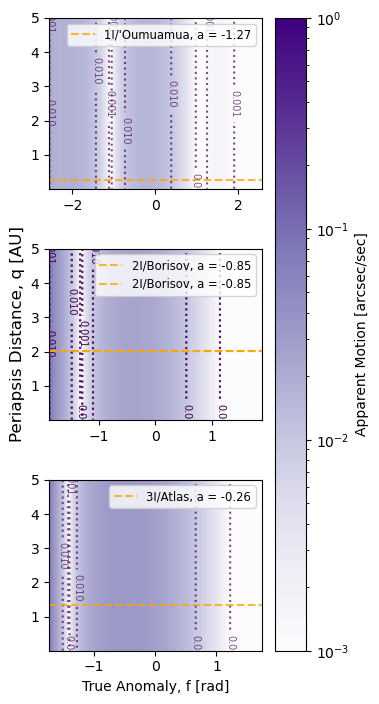

In [36]:
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8.7*cm, 2.4*8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})


labels = [f'1I/\'Oumuamua, a = {a_1I:.2f}', f'2I/Borisov, a = {a_2I:.2f}', f'3I/Atlas, a = {a_3I:.2f}',]
a_vals = [a_1I, a_2I, a_3I]
e_vals = [e_1I, e_2I, e_3I]

peri_distvals = np.linspace(0.01, 5, 1000) #perifocal distance q = a(1-e)
f_earth = np.pi/2

colornorm = colors.LogNorm(vmin=1E-3, vmax=1)
contourlevels = [0.001, 0.01, 0.1, 1]

for i in range(0,3):
    make_plot(i, labels[i], a_vals[i], e_vals[i], peri_distvals, f_earth, colornorm, contourlevels)
    if i==1: 
        colorplot = make_plot(i, labels[i], a_vals[i], e_vals[i], peri_distvals, f_earth, colornorm, contourlevels)

axs[2].set_xlabel('True Anomaly, f [rad]')
axs[1].set_ylabel('Periapsis Distance, q [AU]', fontsize = 'large')
fig.colorbar(colorplot, ax=axs, norm=colornorm, label='Apparent Motion [arcsec/sec]')


#### Old Plot

<>:68: SyntaxWarning: invalid escape sequence '\l'
<>:68: SyntaxWarning: invalid escape sequence '\l'
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3555293221.py:68: SyntaxWarning: invalid escape sequence '\l'
  axs[2].set_xlabel('True Anomaly, |f| $\leq$ arccos(-1/e)')
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: divide by zero encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:9: RuntimeWarning: invalid value encountered in subtract
  factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:13: RuntimeWarning: invalid value encountered in subtract
  coeff2 = (1 / ((gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1))**1.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:16: RuntimeWarning: invalid value encountered in add
 

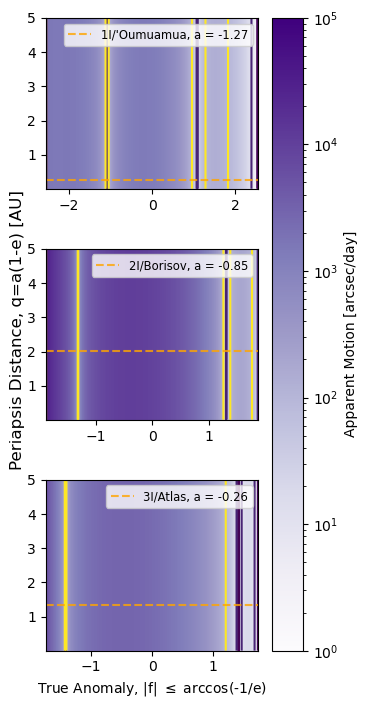

In [37]:
f_values_1I = np.linspace(-calc_hypanomaly_limit(e_1I), calc_hypanomaly_limit(e_1I), 1000)
f_values_2I = np.linspace(-calc_hypanomaly_limit(e_2I), calc_hypanomaly_limit(e_2I), 1000)
f_values_3I = np.linspace(-calc_hypanomaly_limit(e_3I), calc_hypanomaly_limit(e_3I), 1000)
#fearth_values = np.linspace(0, 2*np.pi, 1000)

#a_values = np.linspace(-5, 0, 1000)

#def peri_dist(e):
#    distance_array = a_values*(1-e)
#    return distance_array

peri_distrange = np.linspace(0.01, 5, 1000)

def a_from_periapsis(e):
    a_values = peri_distrange/(1-e)
    return a_values

X1,Y1 = meshgrid(f_values_1I, peri_distrange) 
a_vals_1I = a_from_periapsis(e_1I)
Z1 = 3600*24*206265*calc_appskymotion_solar(a_vals_1I, e_1I, X1, f_earth=np.pi/2)
X2,Y2 = meshgrid(f_values_2I, peri_distrange) 
a_vals_2I = a_from_periapsis(e_2I)
Z2 = 3600*24206265*calc_appskymotion_solar(a_vals_2I, e_2I, X2, f_earth=np.pi/2)
X3,Y3 = meshgrid(f_values_3I, peri_distrange) 
a_vals_3I = a_from_periapsis(e_3I)
Z3 = 3600*24*206265*calc_appskymotion_solar(a_vals_3I, e_3I, X3, f_earth=np.pi/2)

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8.7*cm, 2.4*8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

colornorm = colors.LogNorm(vmin=1, vmax=1E5)
contourlevels = [0.01, 0.1, 1, 10, 100]

#1I/Oumuamua Plot
colorplot1 = axs[0].pcolormesh(f_values_1I, peri_distrange, Z1, cmap='Purples', norm=colornorm)
contours1 = axs[0].contour(X1, Y1, Z1, levels = contourlevels)
#axs[0].set_ylabel('1I/Oumuamua e = 1.20')
periapsis_1I = a_1I*(1-e_1I)
axs[0].axhline(periapsis_1I, linestyle='--', color='orange', alpha=0.8, label='1I/\'Oumuamua, a = -1.27')
#colorbar(colorplot1, label='Apparent Sky Motion (arcsec/sec)')
axs[0].legend(fontsize='small')
#axs[0].set_title('1I/\'Oumuamua, e = 1.20')
#axs[0].clabel(contours1)

#2I/Borisov Plot
colorplot2 = axs[1].pcolormesh(f_values_2I, peri_distrange, Z2,cmap='Purples', norm=colornorm)
contours2 = axs[1].contour(X2,Y2,Z2, levels = contourlevels)
#axs[1].set_ylabel('2I/Borisov e = 3.36')
periapsis_2I = a_2I*(1-e_2I)
axs[1].axhline(periapsis_2I, linestyle='--', color='orange', alpha=0.8, label='2I/Borisov, a = -0.85')
#colorbar(colorplot2, label='Apparent Sky Motion (arcsec/sec)')
axs[1].legend(fontsize='small')
#axs[1].set_title('2I/Borisov, e = 3.36')
#axs[1].clabel(contours2)

#3I/Atlas Plot
colorplot3 = axs[2].pcolormesh(f_values_3I, peri_distrange, Z3,cmap='Purples', norm=colornorm)
contours3= axs[2].contour(X3,Y3, Z3, levels = contourlevels)
#axs[2].set_ylabel('3I/Atlas e = 6.14')
periapsis_3I = a_3I*(1-e_3I)
axs[2].axhline(periapsis_3I, linestyle='--', color='orange', alpha=0.8, label='3I/Atlas, a = -0.26')
#colorbar(colorplot3, label='Apparent Sky Motion (arcsec/sec)')
axs[2].legend(fontsize='small')
#axs[2].set_title('3I/Atlas, e = 6.14')
#axs[2].clabel(contours3)

axs[2].set_xlabel('True Anomaly, |f| $\leq$ arccos(-1/e)')
fig.supylabel('Periapsis Distance, q=a(1-e) [AU]')
fig.colorbar(colorplot1, ax=axs, norm=colornorm, label='Apparent Motion [arcsec/day]')

#plt.savefig('fISO_vs_q_3xplot_wcont',bbox_inches='tight', dpi=600)

## Apparent motion (true anomaly, semimajor axis)
##### Set eccentricity, earth true anomaly

In [38]:
skymot_peri1 = 206265*calc_appskymotion_solar(a_1I, e_1I, f=0, f_earth=np.pi/2)
print(f'\'Oumuamua Sky Motion @ Periapsis = {skymot_peri1} arcsec/sec')
skymot_peri2 = 206265*calc_appskymotion_solar(a_2I, e_2I, f=0, f_earth=np.pi/2)
print(f'Borisov Sky Motion @ Periapsis = {skymot_peri2} arcsec/sec')
skymot_peri3 = 206265*calc_appskymotion_solar(a_3I, e_3I, f=0, f_earth=np.pi/2)
print(f'Atlas Sky Motion @ Periapsis = {skymot_peri3} arcsec/sec')

'Oumuamua Sky Motion @ Periapsis = 0.47063210405001477 arcsec/sec
Borisov Sky Motion @ Periapsis = 0.030157502060340784 arcsec/sec
Atlas Sky Motion @ Periapsis = 0.06946067405248113 arcsec/sec


/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:12: RuntimeWarning: divide by zero encountered in divide
  coeff1 = ((G * M_sun) / (a*(1 - (e**2))))**0.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:12: RuntimeWarning: invalid value encountered in sqrt
  coeff1 = ((G * M_sun) / (a*(1 - (e**2))))**0.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: divide by zero encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: invalid value encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:9: RuntimeWarning: invalid value encountered in subtract
  factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:13: Ru

Text(0, 0.5, 'True Anomaly, |f|')

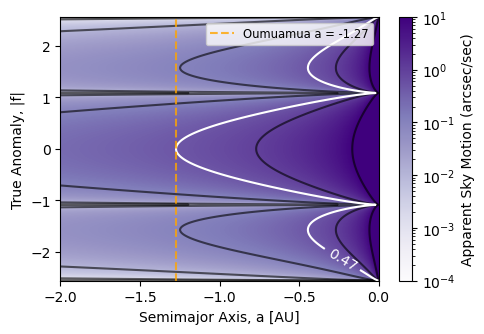

In [39]:
def trueanomalyrange(e):
    fvals =  np.linspace(-calc_hypanomaly_limit(e_1I), calc_hypanomaly_limit(e_1I), 1000)
    return fvals

def distfromsun_range(a, e, frange): #gives me 1000 distances from sun for given orbit
    rvals = []
    frange = trueanomalyrange(e)
    for f in frange:  #each f corresponds to a distance for a given a and e
        r = (a)*(1-(e**2)) / (1+(e*np.cos(f)))
        rvals.append(r)
    return rvals

def r_a_skymotion_grid(a, e, fvals, f_earth): #each a corresponds to a possible range of distances for a given eccentricity
#    fvals = trueanomalyrange(e)
#    rvals = distfromsun_range(a, e, fvals)
    X,Y = meshgrid(avals, rvals) 
    Z = 206265*calc_appskymotion_solar(a, X, fvals, f_earth)   #(a, e, f, f_earth)
    return X,Y,Z

a_values = np.linspace(-2, 0, 1000)
#fearth_values = np.linspace(0, 2*np.pi, 1000)

X1,Y1 = meshgrid(a_values, f_values_1I) 
Z1 = 206265*calc_appskymotion_solar(X1, e_1I, Y1, f_earth=np.pi/2)
X2,Y2 = meshgrid(a_values, f_values_2I) 
Z2 = 206265*calc_appskymotion_solar(X2, e_2I, Y2, f_earth=np.pi/2)
X3,Y3 = meshgrid(a_values, f_values_3I) 
Z3 = 206265*calc_appskymotion_solar(X3, e_3I, Y3, f_earth=np.pi/2)

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(1.5*8.7*cm, 8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

#fig, axs = plt.subplots(1, 3, tight_layout=False,figsize=(18,6),sharex=False,sharey=False
#                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

colorrange=colors.LogNorm(vmin= 1E-4, vmax= 10)
contourlvls = [1E-4, 1E-3, 1E-2, 0.1, 1, 10]

#1I/Oumuamua Plot
colorplot1 = axs.pcolormesh(a_values, f_values_1I, Z1, cmap='Purples', norm=colorrange)
contours1 = axs.contour(X1, Y1, Z1, levels = contourlvls, colors=['k'], alpha=0.6)
contours11 = axs.contour(X1, Y1, Z1, levels = [0.47], colors=['white'])
#axs[0].contour(X1,Y1,Z1, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
#axs[0].set_ylabel('True Anomaly Range (Oumuamua e = 1.20)')
#axs[0].set_xlabel('Hyperbolic Semimajor Axis, a [AU]')
axs.axvline(a_1I, linestyle='--', color='orange', alpha=0.8, label='Oumuamua a = -1.27')
colorbar(colorplot1, label='Apparent Sky Motion (arcsec/sec)')
axs.legend(fontsize='small')
axs.clabel(contours11)
axs.set_xlabel('Semimajor Axis, a [AU]')
axs.set_ylabel('True Anomaly, |f|')

#plt.savefig('Oumuamua_SkyMot_avsf_arcsec_sec',bbox_inches='tight', dpi=600)

/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:12: RuntimeWarning: divide by zero encountered in divide
  coeff1 = ((G * M_sun) / (a*(1 - (e**2))))**0.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:12: RuntimeWarning: invalid value encountered in sqrt
  coeff1 = ((G * M_sun) / (a*(1 - (e**2))))**0.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: divide by zero encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: invalid value encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:9: RuntimeWarning: invalid value encountered in subtract
  factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:13: Ru

Text(0, 0.5, 'True Anomaly, |f|')

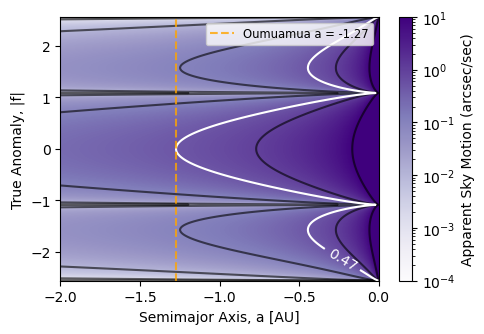

In [40]:
f_values_1I = np.linspace(-calc_hypanomaly_limit(e_1I), calc_hypanomaly_limit(e_1I), 1000)
f_values_2I = np.linspace(-calc_hypanomaly_limit(e_2I), calc_hypanomaly_limit(e_2I), 1000)
f_values_3I = np.linspace(-calc_hypanomaly_limit(e_3I), calc_hypanomaly_limit(e_3I), 1000)
a_values = np.linspace(-2, 0, 1000)
#fearth_values = np.linspace(0, 2*np.pi, 1000)

X1,Y1 = meshgrid(a_values, f_values_1I) 
Z1 = 206265*calc_appskymotion_solar(X1, e_1I, Y1, f_earth=np.pi/2)
X2,Y2 = meshgrid(a_values, f_values_2I) 
Z2 = 206265*calc_appskymotion_solar(X2, e_2I, Y2, f_earth=np.pi/2)
X3,Y3 = meshgrid(a_values, f_values_3I) 
Z3 = 206265*calc_appskymotion_solar(X3, e_3I, Y3, f_earth=np.pi/2)

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(1.5*8.7*cm, 8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

#fig, axs = plt.subplots(1, 3, tight_layout=False,figsize=(18,6),sharex=False,sharey=False
#                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

colorrange=colors.LogNorm(vmin= 1E-4, vmax= 10)
contourlvls = [1E-4, 1E-3, 1E-2, 0.1, 1, 10]

#1I/Oumuamua Plot
colorplot1 = axs.pcolormesh(a_values, f_values_1I, Z1, cmap='Purples', norm=colorrange)
contours1 = axs.contour(X1, Y1, Z1, levels = contourlvls, colors=['k'], alpha=0.6)
contours11 = axs.contour(X1, Y1, Z1, levels = [0.47], colors=['white'])
#axs[0].contour(X1,Y1,Z1, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
#axs[0].set_ylabel('True Anomaly Range (Oumuamua e = 1.20)')
#axs[0].set_xlabel('Hyperbolic Semimajor Axis, a [AU]')
axs.axvline(a_1I, linestyle='--', color='orange', alpha=0.8, label='Oumuamua a = -1.27')
colorbar(colorplot1, label='Apparent Sky Motion (arcsec/sec)')
axs.legend(fontsize='small')
axs.clabel(contours11)
axs.set_xlabel('Semimajor Axis, a [AU]')
axs.set_ylabel('True Anomaly, |f|')

#plt.savefig('Oumuamua_SkyMot_avsf_arcsec_sec',bbox_inches='tight', dpi=600)

/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:12: RuntimeWarning: divide by zero encountered in divide
  coeff1 = ((G * M_sun) / (a*(1 - (e**2))))**0.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:12: RuntimeWarning: invalid value encountered in sqrt
  coeff1 = ((G * M_sun) / (a*(1 - (e**2))))**0.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: divide by zero encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: invalid value encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:9: RuntimeWarning: invalid value encountered in subtract
  factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:13: Ru

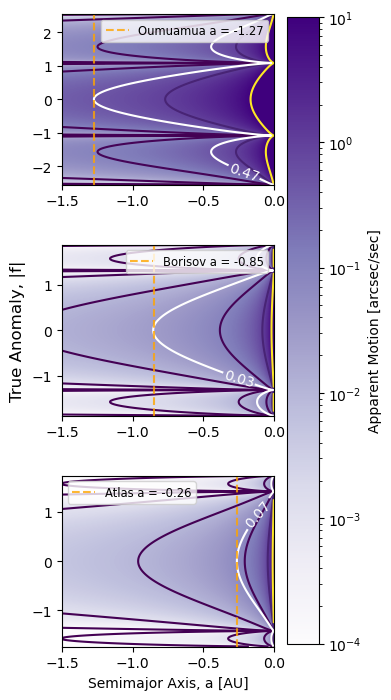

In [41]:
f_values_1I = np.linspace(-calc_hypanomaly_limit(e_1I), calc_hypanomaly_limit(e_1I), 1000)
f_values_2I = np.linspace(-calc_hypanomaly_limit(e_2I), calc_hypanomaly_limit(e_2I), 1000)
f_values_3I = np.linspace(-calc_hypanomaly_limit(e_3I), calc_hypanomaly_limit(e_3I), 1000)
a_values = np.linspace(-1.5, 0, 1000)
#fearth_values = np.linspace(0, 2*np.pi, 1000)

X1,Y1 = meshgrid(a_values, f_values_1I) 
Z1 = 206265*calc_appskymotion_solar(X1, e_1I, Y1, f_earth=np.pi/2)
X2,Y2 = meshgrid(a_values, f_values_2I) 
Z2 = 206265*calc_appskymotion_solar(X2, e_2I, Y2, f_earth=np.pi/2)
X3,Y3 = meshgrid(a_values, f_values_3I) 
Z3 = 206265*calc_appskymotion_solar(X3, e_3I, Y3, f_earth=np.pi/2)

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8.7*cm, 2.4*8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

#fig, axs = plt.subplots(1, 3, tight_layout=False,figsize=(18,6),sharex=False,sharey=False
#                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

colorrange=colors.LogNorm(vmin= 1E-4, vmax= 10)
contourlvls = [1E-4, 1E-3, 1E-2, 0.1, 1, 10]

#1I/Oumuamua Plot
colorplot1 = axs[0].pcolormesh(a_values, f_values_1I, Z1, cmap='Purples', norm=colorrange)
contours1 = axs[0].contour(X1, Y1, Z1, levels = contourlvls)
contours11 = axs[0].contour(X1, Y1, Z1, levels = [0.47], colors=['white'])
#axs[0].contour(X1,Y1,Z1, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
#axs[0].set_ylabel('True Anomaly Range (Oumuamua e = 1.20)')
#axs[0].set_xlabel('Hyperbolic Semimajor Axis, a [AU]')
axs[0].axvline(a_1I, linestyle='--', color='orange', alpha=0.8, label='Oumuamua a = -1.27')
#colorbar(colorplot1, label='Apparent Sky Motion (arcsec/sec)')
axs[0].legend(fontsize='small')
axs[0].clabel(contours11)

#2I/Borisov Plot
colorplot2 = axs[1].pcolormesh(a_values, f_values_2I, Z2,cmap='Purples', norm=colorrange)
contours2 = axs[1].contour(X2,Y2,Z2, levels = contourlvls)
contours21 = axs[1].contour(X2, Y2, Z2, levels = [0.03], colors=['white'])
#axs[1].contour(X2,Y2,Z2, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
#axs[1].set_ylabel('True Anomaly (Borisov e = 3.36)')
#axs[1].set_xlabel('Hyperbolic Semimajor Axis, a [AU]')
axs[1].axvline(a_2I, linestyle='--', color='orange', alpha=0.8, label='Borisov a = -0.85')
#colorbar(colorplot2, label='Apparent Sky Motion (arcsec/sec)')
axs[1].legend(fontsize='small')
axs[1].clabel(contours21)
#axs[1].clabel(contours2)

#3I/Atlas Plot
colorplot3 = axs[2].pcolormesh(a_values, f_values_3I, Z3,cmap='Purples', norm=colorrange)
contours3 = axs[2].contour(X3,Y3,Z3, levels = contourlvls)
contours31 = axs[2].contour(X3, Y3, Z3, levels = [0.07], colors=['white'])
#contours31 = axs[22].contour(X3,Y3,Z3, levels = contourlvls)
#axs[2].contour(X3,Y3,Z3, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
#axs[2].set_ylabel('True Anomaly Range (Atlas e = 6.14)')
#axs[2].set_xlabel('Hyperbolic Semimajor Axis, a [AU]')
axs[2].axvline(a_3I, linestyle='--', color='orange', alpha=0.8, label='Atlas a = -0.26')
#colorbar(colorplot3, label='Apparent Sky Motion (arcsec/sec)')
axs[2].legend(fontsize='small')
axs[2].clabel(contours31)
#axs[2].clabel(contours3)

axs[2].set_xlabel('Semimajor Axis, a [AU]')
axs[1].set_ylabel('True Anomaly, |f|', fontsize='large')
fig.colorbar(colorplot1, ax=axs, norm=colornorm, label='Apparent Motion [arcsec/sec]', shrink=0.99)

#plt.savefig('a_vs_fISO_3x_arcsec_sec_wISO',bbox_inches='tight', dpi=600)

## Apparent motion (object true anomaly, earth true anomaly)
##### Set semimajor axis, eccentricity

/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:7: RuntimeWarning: divide by zero encountered in divide
  gamma = a*(1-(e**2)) / (1+(e*np.cos(f)))
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:9: RuntimeWarning: invalid value encountered in subtract
  factor1 = (gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:13: RuntimeWarning: invalid value encountered in subtract
  coeff2 = (1 / ((gamma**2) - (2*gamma*np.cos(f-f_earth)) + 1))**1.5
/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/3286791748.py:16: RuntimeWarning: invalid value encountered in add
  yterm = ( -factor1*(e + np.cos(f)) ) + ( factor2*(gamma*np.sin(f) - np.sin(f_earth)) )


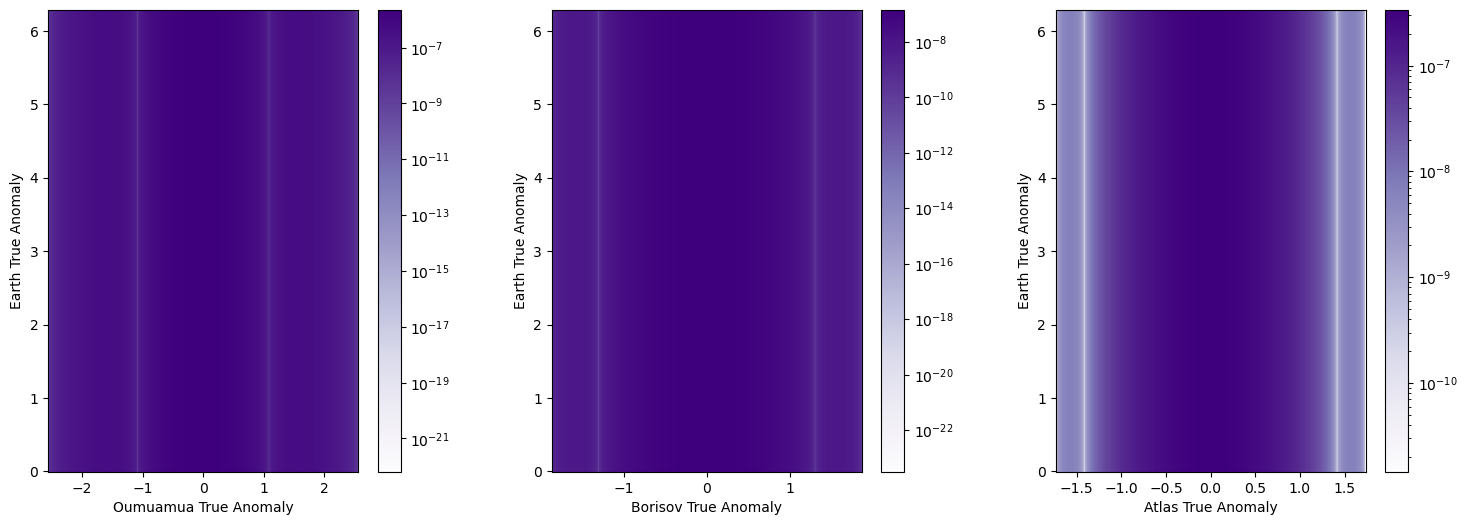

In [42]:
f_values_1I = np.linspace(-calc_hypanomaly_limit(e_1I), calc_hypanomaly_limit(e_1I), 1000)
f_values_2I = np.linspace(-calc_hypanomaly_limit(e_2I), calc_hypanomaly_limit(e_2I), 1000)
f_values_3I = np.linspace(-calc_hypanomaly_limit(e_3I), calc_hypanomaly_limit(e_3I), 1000)
fearth_values = np.linspace(0, 2*np.pi, 1000)

X1,Y1 = meshgrid(f_values_1I, fearth_values) 
Z1 = calc_appskymotion_solar(a_1I, e_1I, X1, Y1)
X2,Y2 = meshgrid(f_values_2I, fearth_values) 
Z2 = calc_appskymotion_solar(a_2I, e_2I, X2, Y2)
X3,Y3 = meshgrid(f_values_3I, fearth_values) 
Z3 = calc_appskymotion_solar(a_3I, e_3I, X3, Y3)

fig, axs = plt.subplots(1, 3, tight_layout=False,figsize=(18,6),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})

#1I/Oumuamua Plot
colorplot1 = axs[0].pcolormesh(f_values_1I, fearth_values, Z1,cmap='Purples', norm=colors.LogNorm())
#axs[0].contour(X1,Y1,Z1, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
axs[0].set_xlabel('Oumuamua True Anomaly')
axs[0].set_ylabel('Earth True Anomaly')
colorbar(colorplot1)

#2I/Borisov Plot
colorplot2 = axs[1].pcolormesh(f_values_2I, fearth_values, Z2,cmap='Purples', norm=colors.LogNorm())
#axs[0].contour(X2,Y2,Z2, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
axs[1].set_xlabel('Borisov True Anomaly')
axs[1].set_ylabel('Earth True Anomaly')
colorbar(colorplot2)

#3I/Atlas Plot
colorplot3 = axs[2].pcolormesh(f_values_3I, fearth_values, Z3,cmap='Purples', norm=colors.LogNorm())
#axs[2].contour(X3,Y3,Z3, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
axs[2].set_xlabel('Atlas True Anomaly')
axs[2].set_ylabel('Earth True Anomaly')
colorbar(colorplot3)

## Apparent motion (object distance from star, eccentricities)
##### Set semimajor axis, earth true anomaly

In [43]:
e_1I, e_2I, e_3I

(1.201133796102373, 3.356475782676596, 6.139587836355706)

/var/folders/bq/jb6ywbx523xg77w6zn_yf6s00000gn/T/ipykernel_73254/2160234676.py:5: RuntimeWarning: divide by zero encountered in divide
  r = (a)*(1-(e**2)) / (1+(e*np.cos(f)))


ValueError: operands could not be broadcast together with shapes (1000,1000000) (1000,) 

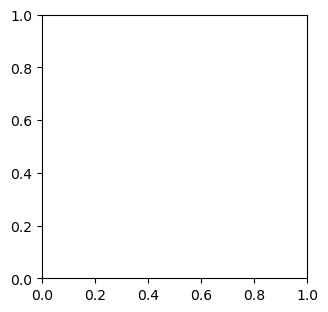

In [44]:
def distfromsun_range(a, e):
    rvals = []
    frange = np.linspace(-calc_hypanomaly_limit(e), calc_hypanomaly_limit(e), 1000)
    for f in frange:
        r = (a)*(1-(e**2)) / (1+(e*np.cos(f)))
        rvals.append(r)
    return rvals

def max_finf(e_range):
    extrema = []
    for e in e_range:
        fmax = calc_hypanomaly_limit(e)
        extrema.append(fmax)
    return max(extrema)

def e_r_skymotion_grid(evals, rvals, a, f_earth):  #plot true anomaly    
    biggestf = max_finf(evals)
    fvals = np.linspace(-biggestf, biggestf, 1000)
    X,Y = meshgrid(rvals, evals) 
    Z = 206265*calc_appskymotion_solar(a, X, fvals, f_earth)   #(a, e, f, f_earth)
    return X,Y,Z


e_range = np.linspace(1.0001,7, 1000)
f_earth = np.pi/2

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(8.7*cm, 8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})
colorrange=colors.LogNorm(vmin= 1E-4, vmax= 10)
contourlvls = [1E-4, 1E-3, 1E-2, 0.1, 1, 10]

#1I/Oumuamua Plot
r_range = distfromsun_range(a_1I, e_range) 
X1, Y1, Z1 = e_r_skymotion_grid(e_range, r_range, a_1I, f_earth)

colorplot1 = axs.pcolormesh(e_range, r_range, Z1, cmap='Purples', norm=colorrange)
contours1 = axs.contour(X1, Y1, Z1, levels = contourlvls, colors=['k'], alpha=0.6)
contours11 = axs.contour(X1, Y1, Z1, levels = [0.47], colors=['white'])
#axs[0].contour(X1,Y1,Z1, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
#axs[0].set_ylabel('True Anomaly Range (Oumuamua e = 1.20)')
#axs[0].set_xlabel('Hyperbolic Semimajor Axis, a [AU]')
axs.axvline(a_1I, linestyle='--', color='orange', alpha=0.8, label='Oumuamua a = -1.27')
colorbar(colorplot1, label='Apparent Sky Motion (arcsec/sec)')
axs.legend(fontsize='small')
axs.clabel(contours11)
axs.set_xlabel('Semimajor Axis, a [AU]')
axs.set_ylabel('True Anomaly, |f|')


## Apparent motion (object distance from star, semimajor axes)

In [ ]:
def trueanomalyrange(e):  #gives me 1000 f's for a given orbit
    frange = np.linspace(-calc_hypanomaly_limit(e), calc_hypanomaly_limit(e), 1000)
    return frange

def distfromsun_range(a, e, frange): #gives me 1000 distances from sun for given orbit
    rvals = []
    frange = trueanomalyrange(e)
    for f in frange:  #each f corresponds to a distance for a given a and e
        r = (a)*(1-(e**2)) / (1+(e*np.cos(f)))
        rvals.append(r)
    return rvals

def r_a_skymotion_grid(a, e, fvals, f_earth): #each a corresponds to a possible range of distances for a given eccentricity
#    fvals = trueanomalyrange(e)
#    rvals = distfromsun_range(a, e, fvals)
    X,Y = meshgrid(avals, rvals) 
    Z = 206265*calc_appskymotion_solar(a, X, fvals, f_earth)   #(a, e, f, f_earth)
    return X,Y,Z

a_range = np.linspace(-1.5, 0, 1000)
f_earth = np.pi/2

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(8.7*cm, 8.7*cm),sharex=False,sharey=False
                       ,gridspec_kw={'hspace': 0.35, 'wspace': 0.3})
colorrange=colors.LogNorm(vmin= 1E-4, vmax= 10)
contourlvls = [1E-4, 1E-3, 1E-2, 0.1, 1, 10]

#1I/Oumuamua Plot
f_range = trueanomalyrange(e_1I)
r_range = distfromsun_range(a_1I, e_1I, f_range) 
X1, Y1, Z1 = e_r_skymotion_grid(a_1I, e_1I, f_range, f_earth)

colorplot1 = axs.pcolormesh(e_range, r_range, Z1, cmap='Purples', norm=colorrange)
contours1 = axs.contour(X1, Y1, Z1, levels = contourlvls, colors=['k'], alpha=0.6)
contours11 = axs.contour(X1, Y1, Z1, levels = [0.47], colors=['white'])
#axs[0].contour(X1,Y1,Z1, levels = [1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 0.01, 0.1, 1])
#axs[0].set_ylabel('True Anomaly Range (Oumuamua e = 1.20)')
#axs[0].set_xlabel('Hyperbolic Semimajor Axis, a [AU]')
axs.axvline(a_1I, linestyle='--', color='orange', alpha=0.8, label='Oumuamua a = -1.27')
colorbar(colorplot1, label='Apparent Sky Motion (arcsec/sec)')
axs.legend(fontsize='small')
axs.clabel(contours11)
axs.set_xlabel('Semimajor Axis, a [AU]')
axs.set_ylabel('True Anomaly, |f|')
